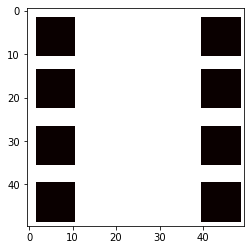

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple, Set, List
from enum import Enum
from itertools import permutations, combinations_with_replacement
import math

class LayoutType(Enum):
    CENTER = 0x00
    SPACED_EVENLY = 0x01
    SPACED_VERTICALLY = 0x02
    SPACED_HORIZONTALLY = 0x03
    
class Shape(Enum):
    CUBE = 0x00
    CIRCLE = 0x01

class RandomExclusionSet(object):
    def __init__(self, n_voids=4, size=5):
        if size % 2 == 0:
            raise ValueError('Size Must Be Odd')
            
        if n_voids %2 != 0:
            raise ValueError('Number of Voids Must Be Even')
            
        self.n_voids = n_voids
        self.size = size
        
    def __len__(self):
        return self.n_voids * self.size
        
class IsotropicVoxelGrid(object):
    def __init__(
        self, 
        dataset_size: int, 
        layout_type: LayoutType, 
        shape: Shape
    ):
        self.grid = np.ones((dataset_size, dataset_size, dataset_size))
        self.layout_type = layout_type
        self.shape = shape
        
    def __call__(self, exclusions: RandomExclusionSet):
        if self.layout_type == LayoutType.CENTER:
            self._set_shape_from_indices(
                self._construct_cube_indices(
                    (self.grid.shape[0]//2, self.grid.shape[1]//2), 2))
                
        elif self.layout_type == LayoutType.SPACED_EVENLY:
            horizontal_space_needed = len(exclusions) + 2 * exclusions.n_voids 
            rows_needed = 1
            elements_per_row = exclusions.n_voids
            
            # Must include appropriate spacing for edge-based voids
            while horizontal_space_needed > self.grid.shape[0] - ((2 * exclusions.size) + 1):
                elements_per_row /= 2
                horizontal_space_needed = elements_per_row * exclusions.size
                rows_needed += 1
                
            # Evenly subdivide along y-axis
            y_axis_origins = np.linspace(
                exclusions.size + 1, 
                self.grid.shape[0]-(exclusions.size + 1), 
                num=rows_needed
            ) if rows_needed > 1 else [math.ceil(self.grid.shape[0] / 2)]
            
            centroids = []
            for row in range(rows_needed):
                x_axis_layout = np.linspace(
                    exclusions.size + 1, 
                    self.grid.shape[0] - (exclusions.size + 1), 
                    num=int(elements_per_row)
                )
                y_axis_val = y_axis_origins[row]
                
                for x_axis_val in x_axis_layout:
                    centroids.append((int(x_axis_val), int(y_axis_val)))
            indices = []
            for centroid in centroids:
                indices.extend(self._construct_cube_indices(centroid, exclusions.size))
                
            self._set_shape_from_indices(indices)
    
    def _set_shape_from_indices(self, indices: List[int]):
        for z in range(self.grid.shape[0]):
            for index in indices:
                self.grid[z][index[0]][index[1]] = 0
    
    def _construct_cube_indices(self, centroid: Tuple[int, int], size: int):
        indices = []
        
        # Top-Half
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x + x, cur_y + y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x - x, cur_y - y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x - x, cur_y + y))
                
        cur_x = centroid[0]
        cur_y = centroid[1]
        for x in range(size):
            for y in range(size):
                indices.append((cur_x + x, cur_y - y))
                
        indices = list(set(indices))
        return indices
    
    def _construct_circle_indices(centroid: Tuple[int, int], size: int):
        raise NotImplemented

isotropic_solver = IsotropicVoxelGrid(50, LayoutType.SPACED_EVENLY, Shape.CUBE)
isotropic_solver(RandomExclusionSet(8, 5))
plt.imshow(isotropic_solver.grid[0], cmap='hot', interpolation='nearest')


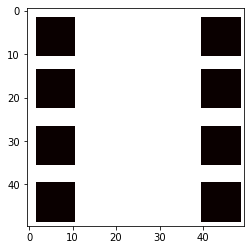

In [3]:
plt.imshow(isotropic_solver.grid[19], cmap='hot', interpolation='nearest')